In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

dataroot = '../WaterLevelPredction_SelectingModel//Data/'

In [2]:
df = pd.read_pickle(dataroot+'finaldata.pkl')

In [3]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=4, test_size=365)
df = df.sort_index()

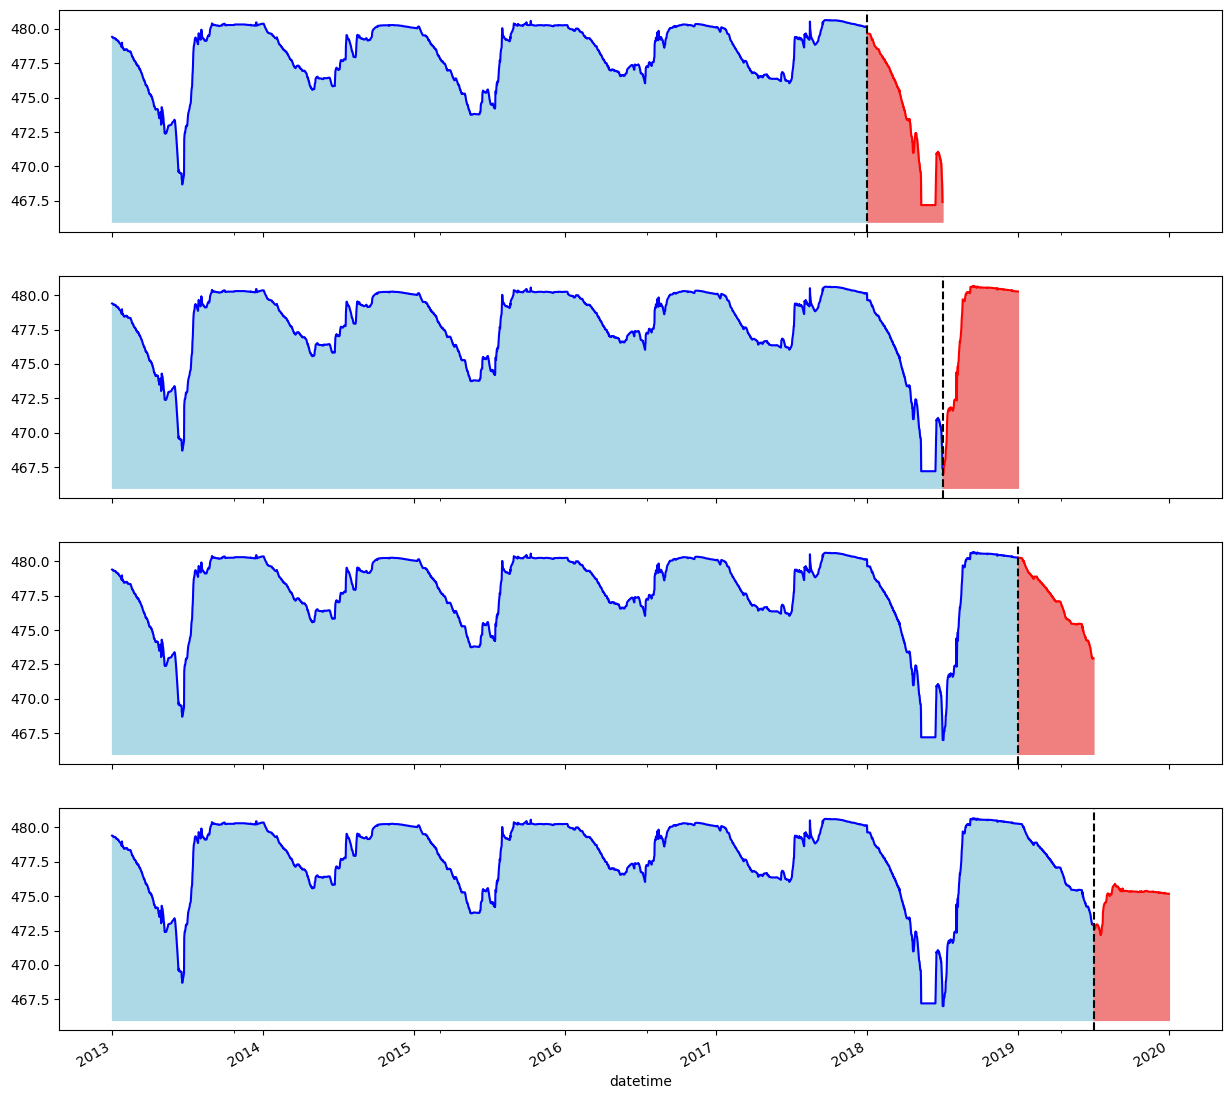

In [4]:
fig, axs = plt.subplots(4,1, figsize = (15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['water_level'].plot(ax=axs[fold],
                              label='Tập huấn luyện',
                              color='blue')
    test['water_level'].plot(ax=axs[fold],
                             label='Tập kiểm thử',
                             color='red')
    axs[fold].fill_between(train.index,466, train['water_level'], color='lightblue')
    axs[fold].fill_between(test.index,466, test['water_level'], color='lightcoral')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold+=1
plt.show()

In [5]:
# Create Lag Feature
def add_lag(df):
    target_map = df['water_level'].to_dict() # mapping water level
    df['lag'] = (df.index - pd.Timedelta('12 hours')).map(target_map)
    return df

df = add_lag(df)
df = df.dropna(subset=['lag'])# drop the NaN value because model won't accept it
df.head()

,year,month,day,water_level,hour,precipitation,sluice_status,datetime,lag
datetime,,,,,,,,,
2013-01-01 19:00:00,2013,1,1,479.38,19,0.0,0,2013-01-01 19:00:00,479.40
2013-01-02 07:00:00,2013,1,2,479.37,7,0.0,5,2013-01-02 07:00:00,479.38
2013-01-02 19:00:00,2013,1,2,479.36,19,0.0,5,2013-01-02 19:00:00,479.37
2013-01-03 07:00:00,2013,1,3,479.36,7,0.0,5,2013-01-03 07:00:00,479.36
2013-01-03 19:00:00,2013,1,3,479.36,19,0.0,5,2013-01-03 19:00:00,479.36


In [6]:
from sklearn.ensemble import RandomForestRegressor

fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['hour','precipitation','sluice_status','lag']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    rf_reg = RandomForestRegressor(n_estimators=100)
    rf_reg.fit(X_train, y_train)
    
    y_pred = rf_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

In [7]:
print(f'mean squared error across fold:{np.mean(rmse)}')
print(f'score for each fold:{rmses}')
print(f'mean absolute error across fold:{np.mean(mae)}')
print(f'score for each fold:{maes}')
print(f'r2 score across fold:{np.mean(r2)}')
print(f'score for each fold:{r2s}')

mean squared error across fold:0.0791464936157306
score for each fold:[0.8019580169623515, 0.22094826023886316, 0.10050733133141686, 0.0791464936157306]
mean absolute error across fold:0.05041746743861246
score for each fold:[0.4136294654295407, 0.11944152618803615, 0.04449086169754553, 0.05041746743861246]
r2 score across fold:0.9921223237315415
score for each fold:[0.9643364403661173, 0.9968172097879575, 0.9973283974464836, 0.9921223237315415]


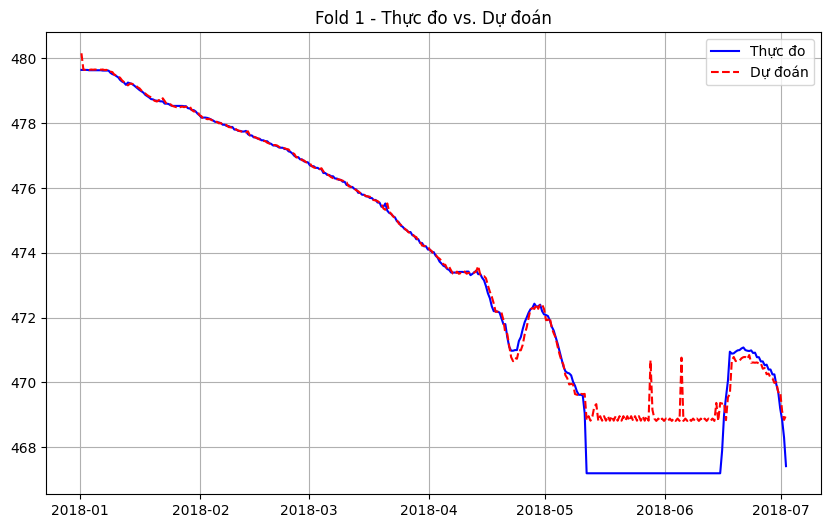

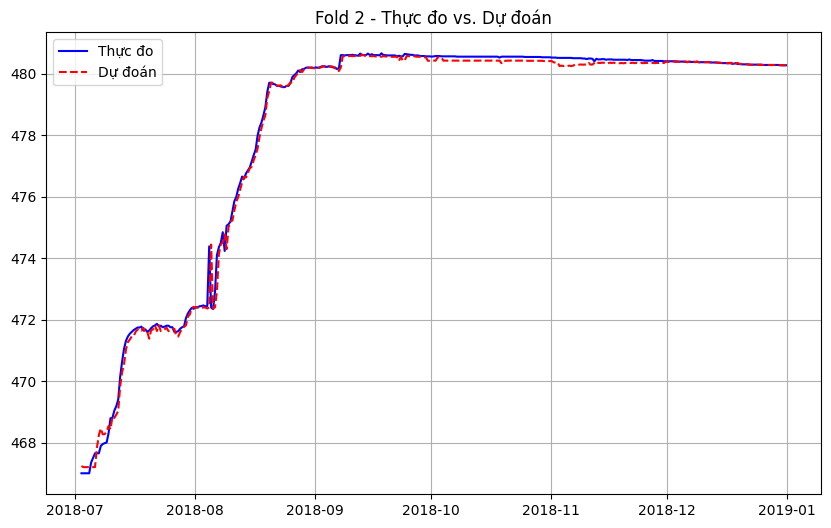

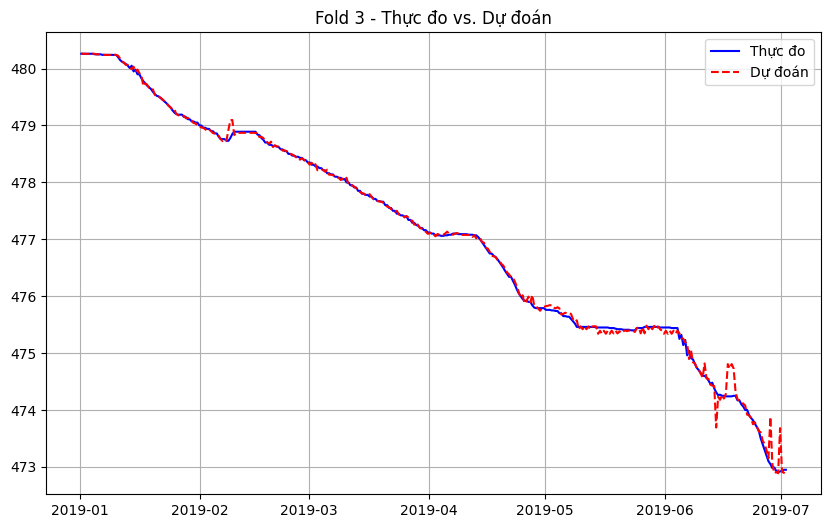

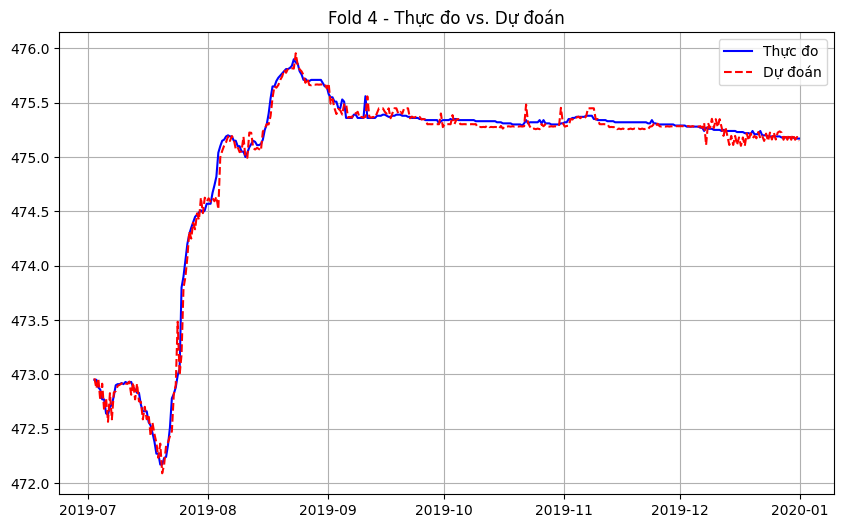

In [8]:
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['water_level'], label='Thực đo', color='blue')
    plt.plot(test.index, preds[fold], label='Dự đoán', color='red', linestyle='dashed')
    fold += 1

    plt.title('Fold {} - Thực đo vs. Dự đoán'.format(fold))

    plt.legend()
    plt.grid()
    plt.show()